In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 11.3 MB/s 


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat



--2022-11-15 11:29:07--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2022-11-15 11:29:07--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  3.10MB/s    in 1.8s    

2022-11-15 11:29:09 (3.10 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2022-11-15 11:29:10--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connectin

# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [ ]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.5445 - accuracy: 0.2010

13/13 [==============================] - 13s 222ms/step - loss: 2.5445 - accuracy: 0.2010
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 1.9359 - accuracy: 0.3662

13/13 [==============================] - 3s 202ms/step - loss: 1.9355 - accuracy: 0.3663
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 1.1634 - accuracy: 0.6263

13/13 [==============================] - 3s 201ms/step - loss: 1.1627 - accuracy: 0.6265
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 0.6592 - accuracy: 0.7923

13/13 [==============================] - 3s 204ms/step - loss: 0.6588 - accuracy: 0.7925
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3767 - accuracy: 0.8831

13/13 [==============================] - 3s 193ms/step - loss: 0.3766 - accuracy: 0.8832
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3739 - accuracy: 0.8848

13/13 [==============================] - 3s 194ms/step - loss: 0.3748 - accuracy: 0.8842
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3810 - accuracy: 0.8805

13/13 [==============================] - 3s 193ms/step - loss: 0.3808 - accuracy: 0.8806
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1909 - accuracy: 0.9411

13/13 [==============================] - 3s 194ms/step - loss: 0.1909 - accuracy: 0.9411
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1278 - accuracy: 0.9648

13/13 [==============================] - 3s 195ms/step - loss: 0.1277 - accuracy: 0.9649
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0890 - accuracy: 0.9714

13/13 [==============================] - 3s 195ms/step - loss: 0.0890 - accuracy: 0.9714
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0701 - accuracy: 0.9801

13/13 [==============================] - 3s 195ms/step - loss: 0.0701 - accuracy: 0.9802
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0502 - accuracy: 0.9863

13/13 [==============================] - 3s 195ms/step - loss: 0.0502 - accuracy: 0.9863
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0417 - accuracy: 0.9893

13/13 [==============================] - 3s 195ms/step - loss: 0.0416 - accuracy: 0.9893
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0526 - accuracy: 0.9867

13/13 [==============================] - 3s 196ms/step - loss: 0.0525 - accuracy: 0.9867
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0432 - accuracy: 0.9880

13/13 [==============================] - 3s 197ms/step - loss: 0.0431 - accuracy: 0.9880
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0357 - accuracy: 0.9880

13/13 [==============================] - 3s 196ms/step - loss: 0.0356 - accuracy: 0.9880
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0220 - accuracy: 0.9945

13/13 [==============================] - 3s 196ms/step - loss: 0.0219 - accuracy: 0.9945
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0318 - accuracy: 0.9915

13/13 [==============================] - 3s 197ms/step - loss: 0.0318 - accuracy: 0.9915
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0146 - accuracy: 0.9958

13/13 [==============================] - 3s 197ms/step - loss: 0.0146 - accuracy: 0.9958
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0197 - accuracy: 0.9948

13/13 [==============================] - 3s 197ms/step - loss: 0.0197 - accuracy: 0.9948
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0230 - accuracy: 0.9935

13/13 [==============================] - 3s 197ms/step - loss: 0.0229 - accuracy: 0.9935
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0212 - accuracy: 0.9919

13/13 [==============================] - 3s 197ms/step - loss: 0.0212 - accuracy: 0.9919
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0128 - accuracy: 0.9964

13/13 [==============================] - 3s 198ms/step - loss: 0.0129 - accuracy: 0.9964
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1061 - accuracy: 0.9834

13/13 [==============================] - 3s 198ms/step - loss: 0.1060 - accuracy: 0.9834
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0538 - accuracy: 0.9867

13/13 [==============================] - 3s 198ms/step - loss: 0.0538 - accuracy: 0.9867
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0378 - accuracy: 0.9896

13/13 [==============================] - 3s 198ms/step - loss: 0.0379 - accuracy: 0.9896
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0364 - accuracy: 0.9886

13/13 [==============================] - 3s 198ms/step - loss: 0.0364 - accuracy: 0.9886
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0272 - accuracy: 0.9902

13/13 [==============================] - 3s 199ms/step - loss: 0.0272 - accuracy: 0.9902
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0249 - accuracy: 0.9928

13/13 [==============================] - 3s 200ms/step - loss: 0.0248 - accuracy: 0.9928
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0160 - accuracy: 0.9948

13/13 [==============================] - 3s 201ms/step - loss: 0.0160 - accuracy: 0.9948
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0122 - accuracy: 0.9967

13/13 [==============================] - 3s 200ms/step - loss: 0.0122 - accuracy: 0.9967
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9967

13/13 [==============================] - 3s 200ms/step - loss: 0.0123 - accuracy: 0.9967
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0103 - accuracy: 0.9974

13/13 [==============================] - 3s 200ms/step - loss: 0.0103 - accuracy: 0.9974
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9958

13/13 [==============================] - 3s 200ms/step - loss: 0.0117 - accuracy: 0.9958
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0140 - accuracy: 0.9948

13/13 [==============================] - 3s 200ms/step - loss: 0.0140 - accuracy: 0.9948
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0071 - accuracy: 0.9974

13/13 [==============================] - 3s 201ms/step - loss: 0.0071 - accuracy: 0.9974
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9964

13/13 [==============================] - 3s 200ms/step - loss: 0.0133 - accuracy: 0.9964
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0193 - accuracy: 0.9958

13/13 [==============================] - 3s 201ms/step - loss: 0.0193 - accuracy: 0.9958
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0149 - accuracy: 0.9948

13/13 [==============================] - 3s 201ms/step - loss: 0.0149 - accuracy: 0.9948
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0193 - accuracy: 0.9967

13/13 [==============================] - 3s 201ms/step - loss: 0.0193 - accuracy: 0.9967
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0164 - accuracy: 0.9958

13/13 [==============================] - 3s 201ms/step - loss: 0.0163 - accuracy: 0.9958
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9977

13/13 [==============================] - 3s 202ms/step - loss: 0.0081 - accuracy: 0.9977
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 0.9987

13/13 [==============================] - 3s 203ms/step - loss: 0.0042 - accuracy: 0.9987
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0086 - accuracy: 0.9984

13/13 [==============================] - 3s 202ms/step - loss: 0.0086 - accuracy: 0.9984
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0055 - accuracy: 0.9977

13/13 [==============================] - 3s 202ms/step - loss: 0.0055 - accuracy: 0.9977
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9974

13/13 [==============================] - 3s 203ms/step - loss: 0.0074 - accuracy: 0.9974
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9987

13/13 [==============================] - 3s 205ms/step - loss: 0.0052 - accuracy: 0.9987
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9980

13/13 [==============================] - 3s 205ms/step - loss: 0.0082 - accuracy: 0.9980
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993

13/13 [==============================] - 3s 204ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9977

13/13 [==============================] - 3s 204ms/step - loss: 0.0062 - accuracy: 0.9977
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0036 - accuracy: 0.9990

13/13 [==============================] - 3s 204ms/step - loss: 0.0036 - accuracy: 0.9990
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0214 - accuracy: 0.9961

13/13 [==============================] - 3s 204ms/step - loss: 0.0214 - accuracy: 0.9961
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9987

13/13 [==============================] - 3s 204ms/step - loss: 0.0045 - accuracy: 0.9987
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

13/13 [==============================] - 3s 204ms/step - loss: 0.0056 - accuracy: 0.9987
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

13/13 [==============================] - 3s 204ms/step - loss: 0.0071 - accuracy: 0.9980
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9974

13/13 [==============================] - 3s 205ms/step - loss: 0.0110 - accuracy: 0.9974
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0093 - accuracy: 0.9977

13/13 [==============================] - 3s 205ms/step - loss: 0.0093 - accuracy: 0.9977
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0103 - accuracy: 0.9974

13/13 [==============================] - 3s 205ms/step - loss: 0.0103 - accuracy: 0.9974
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9974

13/13 [==============================] - 3s 206ms/step - loss: 0.0082 - accuracy: 0.9974
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9993

13/13 [==============================] - 3s 206ms/step - loss: 0.0038 - accuracy: 0.9993
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9977

13/13 [==============================] - 3s 206ms/step - loss: 0.0081 - accuracy: 0.9977
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0131 - accuracy: 0.9974

13/13 [==============================] - 3s 207ms/step - loss: 0.0131 - accuracy: 0.9974
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0134 - accuracy: 0.9967

13/13 [==============================] - 3s 207ms/step - loss: 0.0134 - accuracy: 0.9967
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993

13/13 [==============================] - 3s 207ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 0.9997

13/13 [==============================] - 3s 206ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0057 - accuracy: 0.9990
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0088 - accuracy: 0.9984

13/13 [==============================] - 3s 205ms/step - loss: 0.0088 - accuracy: 0.9984
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 0.9993

13/13 [==============================] - 3s 206ms/step - loss: 0.0017 - accuracy: 0.9993
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0045 - accuracy: 0.9990
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0021 - accuracy: 0.9990
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0047 - accuracy: 0.9987

13/13 [==============================] - 3s 206ms/step - loss: 0.0047 - accuracy: 0.9987
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0027 - accuracy: 0.9990
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997

13/13 [==============================] - 3s 205ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0057 - accuracy: 0.9990
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0024 - accuracy: 0.9990
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9980

13/13 [==============================] - 3s 206ms/step - loss: 0.0052 - accuracy: 0.9980
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - accuracy: 0.9993

13/13 [==============================] - 3s 206ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9990

13/13 [==============================] - 3s 208ms/step - loss: 0.0046 - accuracy: 0.9990
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0108 - accuracy: 0.9977

13/13 [==============================] - 3s 207ms/step - loss: 0.0108 - accuracy: 0.9977
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993

13/13 [==============================] - 3s 206ms/step - loss: 0.0029 - accuracy: 0.9993
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 0.9987

13/13 [==============================] - 3s 207ms/step - loss: 0.0026 - accuracy: 0.9987
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0054 - accuracy: 0.9987

13/13 [==============================] - 3s 207ms/step - loss: 0.0053 - accuracy: 0.9987
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0111 - accuracy: 0.9980

13/13 [==============================] - 3s 209ms/step - loss: 0.0111 - accuracy: 0.9980
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9984

13/13 [==============================] - 3s 209ms/step - loss: 0.0081 - accuracy: 0.9984
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0105 - accuracy: 0.9974

13/13 [==============================] - 3s 207ms/step - loss: 0.0105 - accuracy: 0.9974
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9987

13/13 [==============================] - 3s 208ms/step - loss: 0.0045 - accuracy: 0.9987
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984

13/13 [==============================] - 3s 209ms/step - loss: 0.0057 - accuracy: 0.9984
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9980

13/13 [==============================] - 3s 208ms/step - loss: 0.0050 - accuracy: 0.9980
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9980

13/13 [==============================] - 3s 209ms/step - loss: 0.0052 - accuracy: 0.9980
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0071 - accuracy: 0.9984

13/13 [==============================] - 3s 210ms/step - loss: 0.0071 - accuracy: 0.9984
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0138 - accuracy: 0.9971

13/13 [==============================] - 3s 210ms/step - loss: 0.0138 - accuracy: 0.9971
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9990

13/13 [==============================] - 3s 209ms/step - loss: 0.0025 - accuracy: 0.9990
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993

13/13 [==============================] - 3s 208ms/step - loss: 0.0018 - accuracy: 0.9993
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0060 - accuracy: 0.9990

13/13 [==============================] - 3s 208ms/step - loss: 0.0060 - accuracy: 0.9990
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 0.9987

13/13 [==============================] - 3s 211ms/step - loss: 0.0041 - accuracy: 0.9987
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9987

13/13 [==============================] - 3s 210ms/step - loss: 0.0038 - accuracy: 0.9987
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0048 - accuracy: 0.9977

13/13 [==============================] - 3s 210ms/step - loss: 0.0048 - accuracy: 0.9977
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9993

13/13 [==============================] - 3s 211ms/step - loss: 0.0052 - accuracy: 0.9993
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 0.9987

13/13 [==============================] - 3s 209ms/step - loss: 0.0043 - accuracy: 0.9987
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 0.9984

13/13 [==============================] - 3s 210ms/step - loss: 0.0042 - accuracy: 0.9984


In [ ]:
model.save("best-model.hdf5")

# Validation

In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.99      1.00      1000
           2       1.00      0.99      1.00       581
           3       0.99      1.00      1.00       166
           4       1.00      1.00      1.00       338
           5       0.99      1.00      0.99       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       0.82      1.00      0.90        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      1.00      1.00       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       0.99      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy             

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 3s 11ms/step - loss: 0.0105 - accuracy: 0.9975


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
#@title Default title text
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


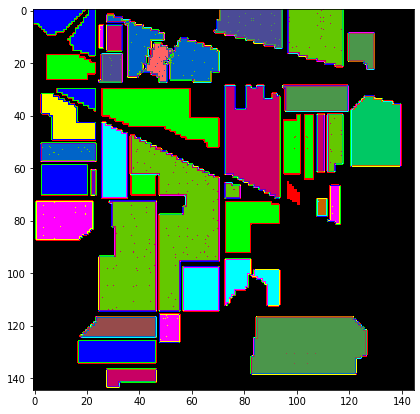

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

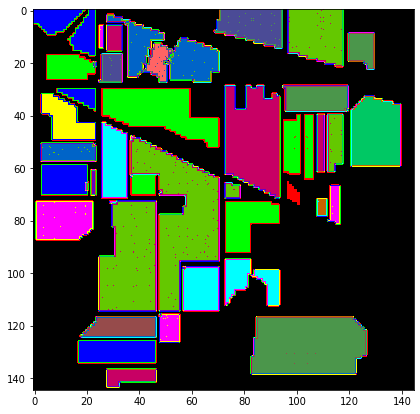

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)